In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Set random seed to 42
np.random.seed(42)

## Exercise 1

46.55379978123649
48.11174031201314


Text(0, 0.5, '$\\sigma$')

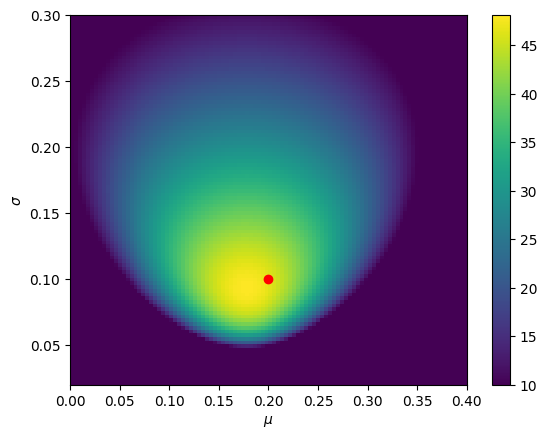

In [97]:

def log_likelihood(f):
    ll = np.sum( np.log( f ))
    return ll

def gauss(x, mu, sigma):
    g = 1/(np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2 / (2*sigma**2))
    return g 

mu_true = 0.2
sigma_true = 0.1
N = 50

data = np.random.normal(mu_true, sigma_true, N)
ll_true = log_likelihood(gauss(data, mu_true, sigma_true))
print(ll_true)

mu_scan = np.linspace(0, 0.4, 100)
sigma_scan = np.linspace(0.02, 0.3, 100)


ll_scan = np.zeros((len(mu_scan), len(sigma_scan)))


for i, mu in enumerate(mu_scan):
    for j, sigma in enumerate(sigma_scan):
        ll = log_likelihood(gauss(data, mu, sigma))
        ll_scan[i, j] = ll

vmin = 10
vmax = np.max(ll_scan)

print(max(ll_scan.flatten()))
plt.imshow(ll_scan.T, extent=(mu_scan[0], mu_scan[-1], sigma_scan[0], sigma_scan[-1]), 
           aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
plt.plot(mu_true, sigma_true, 'ro')
plt.colorbar()
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')


In [98]:
def ll_gauss(N_tries, N_samples, mu_true, sigma_true):
    ll_list = []
    ll_true_list = []
    for i in range(N_tries):
        scan_mu = np.linspace(0, 0.4, 100)
        scan_sigma = np.linspace(0.02, 0.3, 100)
        
        data = np.random.normal(mu_true, sigma_true, N_samples)
        ll_true = log_likelihood(gauss(data, mu_true, sigma_true))
        ll_true_list.append(ll_true)

        ll_scan = np.zeros((len(scan_mu), len(scan_sigma)))
        for i, mu in enumerate(scan_mu):
            for j, sigma in enumerate(scan_sigma):
                ll = log_likelihood(gauss(data, mu, sigma))
                ll_scan[i, j] = ll

        ll_list.append(max(ll_scan.flatten()))
    
    return ll_list, ll_true_list


ll_list, ll_true_list = ll_gauss(N_tries=100, N_samples=50, mu_true=0.2, sigma_true=0.1)

Text(0.5, 1.0, 'Difference between true LL and max LL')

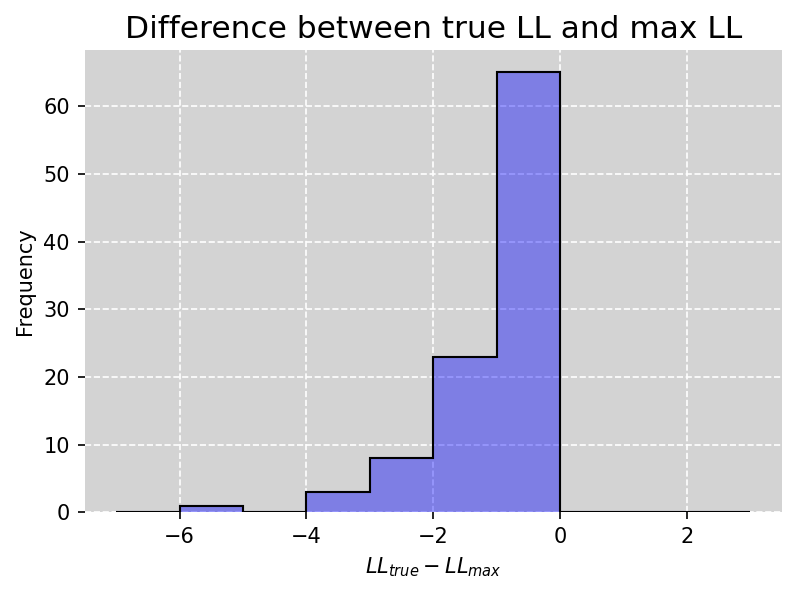

In [99]:
diff_ll = np.array(ll_true_list) - np.array(ll_list)
hist_range = (-7, 3)
# Make a step histogram with fill with alpha 0.4
fig, ax = plt.subplots(1,1, dpi=150, figsize=(6,4))
ax.hist(diff_ll, bins=10, range=hist_range, histtype='step', color='blue', fill=True, alpha=0.4)
# Change the color of the step line
ax.hist(diff_ll, bins=10, range=hist_range, histtype='step', color='k')

# Have a grey background with matplotlib
ax.set_facecolor('lightgrey')

# Remove border on al sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


# Make dashes gridlines
ax.grid(True, which='both', linestyle='--', color='white')

ax.set_xlabel('$LL_{true} - LL_{max}$')
ax.set_ylabel('Frequency')
ax.set_title('Difference between true LL and max LL', fontsize=15)



____

## Exercise 2

In [100]:
from scipy.optimize import minimize

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 324.3223524033722
        x: [ 5.254e-01  5.622e-01]
      nit: 7
      jac: [-2.871e-03  1.103e-03]
     nfev: 27
     njev: 9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
a est.:0.53 +/- 0.1
b est.:0.56 +/- 0.21


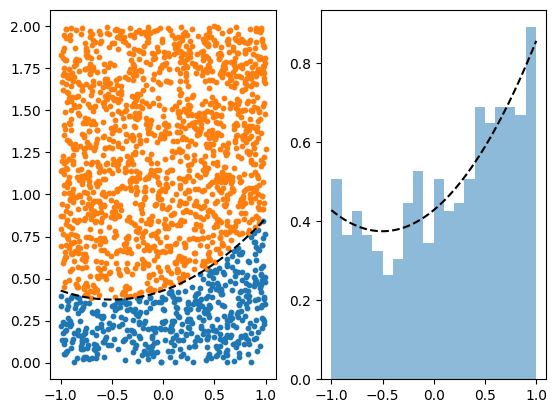

In [136]:
# Nomalized pdf
def norm_pdf(x, alpha, beta):
    return 1/(2 + 2/3 * beta) * (1 + alpha*x + beta*x**2)

def accept_reject(f, params, N_points, interval_x, interval_y):
    x = np.random.uniform(interval_x[0], interval_x[1], N_points)
    y = np.random.uniform(interval_y[0], interval_y[1], N_points)
    f_model = f(x, *params)

    accept = y < f_model
    x_accept = x[accept]
    y_accept = y[accept]
    x_reject = x[~accept]
    y_reject = y[~accept]
    
    return x_accept, y_accept, x_reject, y_reject

def nll(params, x):
    y = norm_pdf(x, *params)
    nll = -np.sum(np.log(y))
    return nll

def raster_scan_2D(pdf, params, acc_rej, scan, scan_N):
    scan_x, scan_y = scan[0], scan[1]

    
    x = np.linspace(scan_x[0], scan_x[1], scan_N)
    y = np.linspace(scan_y[0], scan_y[1], scan_N)
    
    true_ll = nll(params, acc_rej[0])
    
    ll_scan = np.zeros((len(x), len(y)))
    for i, param1 in enumerate(x):
        for j, param2 in enumerate(y):
            ll = nll([param1, param2], acc_rej[0])
            ll_scan[i, j] = ll

    return ll_scan, true_ll

# Parameters
N_points = int(2e3)
x_model = np.linspace(-1, 1, 100)
alpha = 0.5
beta = 0.5
params = (alpha, beta)
interval_x = (-1, 1)
interval_y = (0, 2)

# Accept-reject method
x_accept, y_accept, x_reject, y_reject = accept_reject(norm_pdf, params, N_points, interval_x, interval_y)


# Minimizing the negative log likelihood
initial_guess = [0.1, 0.1]
result = minimize(nll, initial_guess, args=(x_accept,), method='L-BFGS-B')
print(result)
inv_hes = result.hess_inv.todense()
std = np.sqrt(np.diag(inv_hes))
a = result.x[0].round(2)
b = result.x[1].round(2)
std_a = std[0].round(2)
std_b = std[1].round(2)


print(f'a est.:' + str(a) + ' +/- ' + str(std_a))
print(f'b est.:' + str(b) + ' +/- ' + str(std_b))


fig, ax = plt.subplots(1,2)
ax[0].scatter(x_accept, y_accept, s=10, label='accepted')
ax[0].scatter(x_reject, y_reject, s=10, label='rejected')
ax[0].plot(x_model, norm_pdf(x_model, alpha, beta), 'k', marker='', ls='--', label='model')
ax[1].hist(x_accept, bins=20, alpha=0.5, density=True)
ax[1].plot(x_model, norm_pdf(x_model, alpha, beta), 'k', marker='', ls='--', label='model')




2000


C:\Users\Niels\AppData\Local\Temp\ipykernel_5220\2727798508.py:19: RuntimeWarning: invalid value encountered in log
  nll = -np.sum(np.log(norm_pdf(x, *params)))


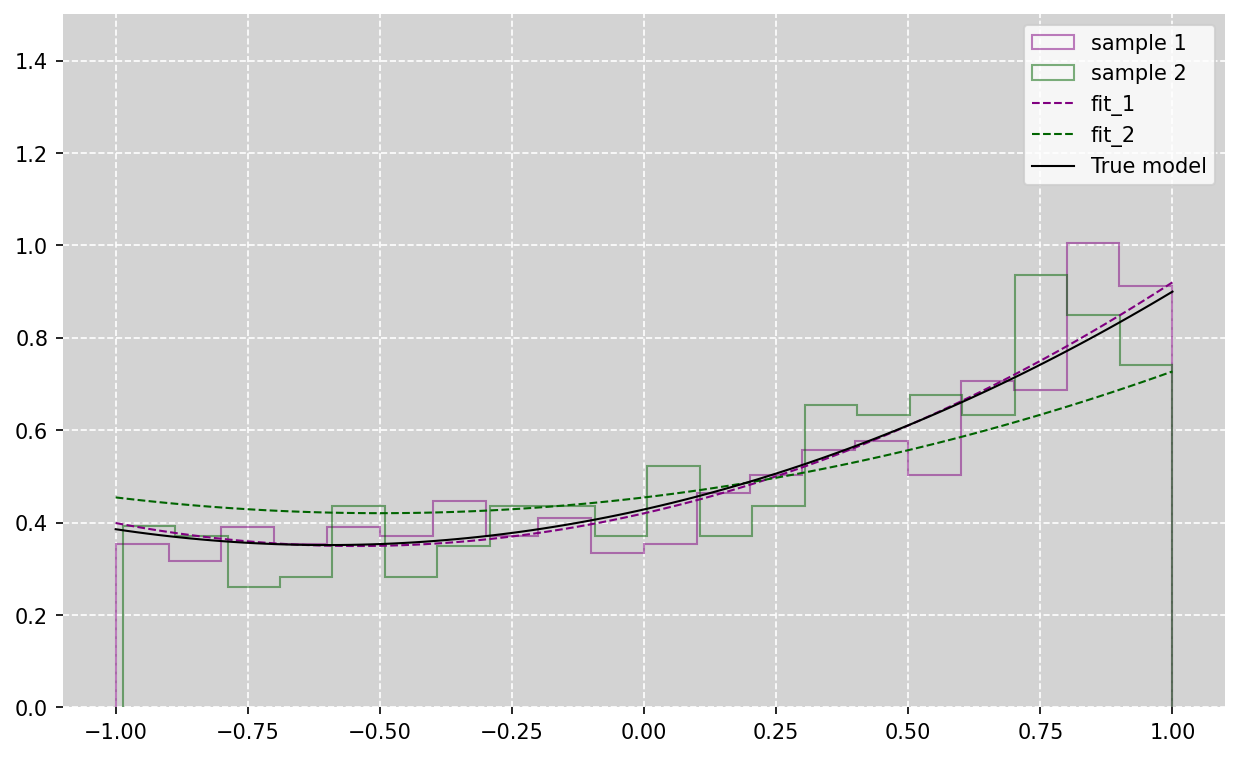

In [102]:
# samples of new parameters
n_points = int(2e3)
print(n_points)
params = (0.6, 0.5)
x_model = np.linspace(-1, 1, 100)

acc_rej_1 = accept_reject(norm_pdf, params, n_points, interval_x, interval_y)
acc_rej_2 = accept_reject(norm_pdf, params, n_points, interval_x, interval_y)

initial_guess = [0.3, 0.3]

results_1 = minimize(nll, initial_guess, args=(acc_rej_1[0],), method='L-BFGS-B')
results_2 = minimize(nll, initial_guess, args=(acc_rej_2[0],), method='L-BFGS-B')

a_1 = results_1.x[0].round(2)
b_1 = results_1.x[1].round(2)
a_2 = results_2.x[0].round(2)
b_2 = results_2.x[1].round(2)

fig, ax = plt.subplots(1,1, dpi=150, figsize=(10,6))
ax.hist(acc_rej_1[0], bins=20, alpha=0.5, density=True, label='sample 1', color='purple', histtype='step')
ax.hist(acc_rej_2[0], bins=20, alpha=0.5, density=True, label='sample 2', color='darkgreen', histtype='step')
ax.plot(x_model, norm_pdf(x_model, a_1, b_1), 'purple', marker='', ls='--', label='fit_1', linewidth=1)
ax.plot(x_model, norm_pdf(x_model, a_2, b_2), 'darkgreen', marker='', ls='--', label='fit_2', linewidth=1)
ax.plot(x_model, norm_pdf(x_model, params[0], params[1]), 'k', marker='', ls='-', label='True model', linewidth=1)
ax.set(ylim=(0, 1.5))
ax.legend()
ax.set_facecolor('lightgrey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(True, which='both', linestyle='--', color='white')

0
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
Negative values in pdf
inf 302.5354922253757
Negative values in pdf
Negative values in pdf
Negative values in pdf
0.3 0.3


c:\Users\Niels\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Text(0, 0.5, '$\\beta$')

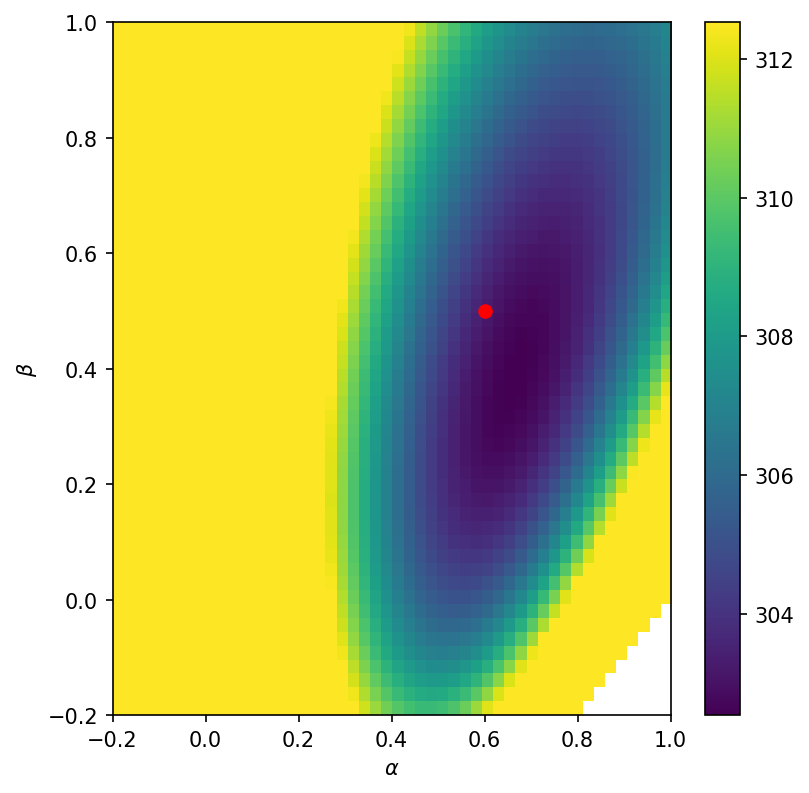

In [ ]:
# Likelihood landscape
alpha = 0.6
beta = 0.5
params = (alpha, beta)
N_points = int(2e3)

scan_x = (-1, 1)
scan_y = (-0.2, 1)
scan = (scan_x, scan_y)
scan_N = 50
interval = ((-1, 1), (0, 2))

acc_rej = accept_reject(norm_pdf, params, N_points, interval_x=interval[0], interval_y=interval[1])

ll_scan, true_ll = raster_scan_2D(norm_pdf, params, acc_rej, scan, scan_N)
max_ll = max(ll_scan.flatten())
min_ll = min(ll_scan.flatten())
print(max_ll, min_ll)

# Minimize likelihood
initial_guess = [0.3, 0.3]
results = minimize(nll, initial_guess, args=(acc_rej[0],), method='L-BFGS-B')
par_1 = results.x[0].round(2)
par_2 = results.x[1].round(2)
print(par_1, par_2)
    
fig_im, ax_im = plt.subplots(1,1, dpi=150, figsize=(6,6))
im = ax_im.imshow(ll_scan.T, extent=(scan_x[0], scan_x[1], scan_y[0], scan_y[1]), 
           aspect='auto', origin='lower', cmap='viridis', vmin=min_ll, vmax=min_ll+10)


ax_im.plot(alpha, beta, 'ro')
plt.colorbar(im)

ax_im.set_xlabel('$\\alpha$')
ax_im.set_ylabel('$\\beta$')
